In [69]:
!pip install --extra-index-url https://pypi.netsquid.org netsquid

Looking in indexes: https://pypi.org/simple, https://pypi.netsquid.org


In [70]:
!pip install skyfield

In [71]:
import skyfield.api
from skyfield.api import load, wgs84, Loader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [72]:
from scipy.special import i0, i1
from numpy.random import weibull
import netsquid as ns
from netsquid.qubits.qformalism import QFormalism
from netsquid.components.models.qerrormodels import QuantumErrorModel
import netsquid.util.simtools as simtools
from netsquid.util.simlog import warn_deprecated
from skyfield.api import Topos, utc
from skyfield.sgp4lib import EarthSatellite
import skyfield.api
from skyfield.api import load, wgs84, Loader
from skyfield.api import Topos, utc
from skyfield.sgp4lib import EarthSatellite
from skyfield.constants import AU_KM, DAY_S
from skyfield.functions import length_of
from skyfield.functions import length_of
from skyfield.positionlib import ICRF
from datetime import datetime, timedelta
from scipy.spatial.distance import euclidean, pdist, squareform

In [73]:
__all__ = [
    'FreeSpaceLossModel',
    'FixedSatelliteLossModel'
]


class FreeSpaceLossModel(QuantumErrorModel):
    """Model for photon loss on a free space channel

    Uses beam-wandering PDTC from [Vasylyev et al., PRL 108, 220501 (2012)] to
    sample the loss probability of the photon.

    Parameters
    ----------
    W0 : float
        Waist of the beam at the transmitter [m].
    rx_aperture : float
        Radius of the receiving telescope [m].
    Cn2 : float
        Index of refraction structure constant [m**(-2/3)].
    wavelength : float
        Wavelength of the radiation [m].
    Tatm : float
        Atmospheric transmittance (square of the transmission coefficient).
    sigmaPoint :
        Pointing error, standard deviation [rad].
    rng : :obj:`~numpy.random.RandomState` or None, optional
        Random number generator to use. If ``None`` then
        :obj:`~netsquid.util.simtools.get_random_state` is used.
    """
    def __init__(self, W0, rx_aperture, Cn2, wavelength, Tatm=1, sigmaPoint=0., rng=None):
        super().__init__()
        self.rng = rng if rng else simtools.get_random_state()
        self.W0 = W0
        self.rx_aperture = rx_aperture
        self.Cn2 = Cn2
        self.wavelength = wavelength
        self.sigmaPoint = sigmaPoint
        self.Tatm = Tatm
        self.required_properties = ['length']

    @property
    def rng(self):
        """ :obj:`~numpy.random.RandomState`: Random number generator."""
        return self.properties['rng']

    @rng.setter
    def rng(self, value):
        if not isinstance(value, np.random.RandomState):
            raise TypeError("{} is not a valid numpy RandomState".format(value))
        self.properties['rng'] = value

    @property
    def sigmaPoint(self):
        """ :float: pointing error at the transmitter [m]."""
        return self.properties['sigmaPoint']

    @sigmaPoint.setter
    def sigmaPoint(self, value):
        if value < 0:
            raise ValueError
        self.properties['sigmaPoint'] = value


    @property
    def Tatm(self):
        """ :float: atmosphere transmittance. """
        return self.properties['Tatm']

    @Tatm.setter
    def Tatm(self, value):
        if (value < 0) or (value > 1):
            raise ValueError
        self.properties['Tatm'] = value

    @property
    def W0(self):
        """float: beam waist at the transmitter [m]."""
        return self.properties['W0']

    @W0.setter
    def W0(self, value):
        if value < 0:
            raise ValueError
        self.properties['W0'] = value

    @property
    def rx_aperture(self):
        """float: radius of the receiving telescope [m]."""
        return self.properties['rx_aperture']

    @rx_aperture.setter
    def rx_aperture(self, value):
        if value < 0:
            raise ValueError
        self.properties['rx_aperture'] = value

    @property
    def Cn2(self):
        """float: index of refraction structure constant [m**(-2/3)]."""
        return self.properties['Cn2']

    @Cn2.setter
    def Cn2(self, value):
        if value < 0:
            raise ValueError
        self.properties['Cn2'] = value

    @property
    def wavelength(self):
        """float: wavelength of the radiation [m]."""
        return self.properties['wavelength']

    @wavelength.setter
    def wavelength(self, value):
        if value < 0:
            raise ValueError
        self.properties['wavelength'] = value

    def _compute_weibull_loss_model_parameters(self, length):
        """ Compute the parameters of the Weibull model

        This function calculates the parameters of the Weibull distribution
        lambda and R, described in equations (6) and (7) of [Vasylyev et al.,
        PRL 108, 220501 (2012)], and the maximal transmission T0, described in
        equation (5) of the same reference.

        It then converts these parameters to the parameters a and scaleL
        required by numpy to sample the Weibull distribution.

        Parameters
        ----------
        length: float
            Length of the channel.

        Returns
        -------
        tuple (float, float, float)
            The elements of the tuple are properties of the
            Weibull distribution. From left to right:
            - the 'shape' parameter
            - the 'scale' parameter
            - 'T0'
        """

        z = length*1e3
        W = self.W0*np.sqrt(1 + (z*self.wavelength/(np.pi*self.W0**2))**2)
        X = (self.rx_aperture/W)**2
        T0 = np.sqrt(1 - np.exp(-2*X))
        sigmaTurb = np.sqrt(1.919 * self.Cn2 * z**3 * (2*self.W0)**(-1./3.))
        sigma = np.sqrt( (self.sigmaPoint*z)**2 + sigmaTurb**2 )
        l = 8 * X * np.exp(-4*X) * i1(4*X) / (1 - np.exp(-4*X)*i0(4*X)) / np.log( 2*T0**2/(1-np.exp(-4*X)*i0(4*X)))
        R = self.rx_aperture * np.log( 2*T0**2/(1-np.exp(-4*X)*i0(4*X)) )**(-1./l)

        # define the parameters of the Weibull distribution
        a = 2/l
        scaleL = (2*(sigma/R)**2)**(l/2)

        return (a, scaleL, T0)

    def _sample_loss_probability(self, length):
        """ Sample the loss probability distribution

        This function samples the Weibull distribution to get the value of the
        channel transmittance, using the parameters calculated in the
        _compute_weibull_loss_model_parameter method.

        It uses the numpy.weibull method to implement the sampling of the
        probability distribution described in equation (9) of [Vasylyev et al.,
        PRL 108, 220501 (2012)].

        Parameters
        ----------
        length: float
            Length of the channel [km].

        Returns
        -------
        float
        """
        a, scaleL, T0 = self._compute_weibull_loss_model_parameters(length=length)

        # extract the value of the transmission coefficient
        x = weibull(a, 1)
        scaleX = scaleL * x
        T = T0*np.exp(-scaleX/2)
        # calculate the probability of losing the qubit
        prob_loss = 1 - self.Tatm * T**2
        return prob_loss

    def error_operation(self, qubits, delta_time=0, **kwargs):
        """Error operation to apply to qubits.

        Parameters
        ----------
        qubits : tuple of :obj:`~netsquid.qubits.qubit.Qubit`
            Qubits to apply noise to.
        delta_time : float, optional
            Time qubits have spent on a component [ns].

        """
        if 'channel' in kwargs:
            warn_deprecated("channel parameter is deprecated. "
                            "Pass length parameter directly instead.",
                            key="FreeSpaceLossModel.compute_model.channel")
            kwargs['length'] = kwargs['channel'].properties["length"]
            del kwargs['channel']


        for idx, qubit in enumerate(qubits):
            if qubit is None:
                continue
            prob_loss = self._sample_loss_probability(length=kwargs['length'])
            self.lose_qubit(qubits, idx, prob_loss, rng=self.properties['rng'])


class FixedSatelliteLossModel(FreeSpaceLossModel):
    """Model for photon loss on a satellite-to-ground static channel

    Uses beam-wandering PDTC from [Vasylyev et al., PRL 108, 220501 (2012)] to
    sample the loss probability of the photon.

    Parameters
    ----------
    txDiv : float
        Divergence of the beam sent from the satellite [rad].
    sigmaPoint :
        Pointing error of the satellite, standard deviation [rad].
    rx_aperture : float
        Radius of the receiving telescope [m].
    Cn2 : float
        Index of refraction structure constant [m**(-2/3)].
    wavelength : float
        Wavelength of the radiation [m].
    Tatm : float
        Atmospheric transmittance (square of the transmission coefficient).
    rng : :obj:`~numpy.random.RandomState` or None, optional
        Random number generator to use. If ``None`` then
        :obj:`~netsquid.util.simtools.get_random_state` is used.
    """
    def __init__(self, txDiv, sigmaPoint, rx_aperture, Cn2, wavelength, Tatm=1, rng=None):
        super().__init__(wavelength/(np.pi*txDiv),rx_aperture,Cn2,wavelength,Tatm,sigmaPoint,rng)
        self.txDiv = txDiv
        self.required_properties = ['length']

    @property
    def txDiv(self):
        """float: divergence of the beam at the transmitter (satellite) [m]."""
        return self.properties['txDiv']

    @txDiv.setter
    def txDiv(self, value):
        if value < 0:
            raise ValueError
        self.properties['txDiv'] = value

    def _compute_weibull_loss_model_parameters(self, length):
        """Compute the parameters of the Weibull model

        This function calculates the parameters of the Weibull distribution
        lambda and R, described in equations (6) and (7) of [Vasylyev et al.,
        PRL 108, 220501 (2012)], and the maximal transmission T0, described in
        equation (5) of the same reference.

        It then converts these parameters to the parameters a and scaleL
        required by numpy to sample the Weibull distribution.

        Parameters
        ----------
        length: float
            Length of the channel.

        Returns
        -------
        tuple (float, float, float)
            The elements of the tuple are properties of the
            Weibull distribution. From left to right:
            - the 'shape' parameter
            - the 'scale' parameter
            - 'T0'
        """

        # this function cannot be used for range values lower than 10 km
        if length <= 10:
            raise ValueError

        z = length*1e3
        W = self.txDiv * z
        X = (self.rx_aperture/W)**2
        T0 = np.sqrt(1 - np.exp(-2*X))
        sigmaTurb = np.sqrt(1.919 * self.Cn2 * 10e3**3 * (2*self.txDiv*(z-10e3))**(-1./3.))
        sigma = np.sqrt( (self.sigmaPoint*z)**2 + sigmaTurb**2 )
        l = 8 * X * np.exp(-4*X) * i1(4*X) / (1 - np.exp(-4*X)*i0(4*X)) / np.log( 2*T0**2/(1-np.exp(-4*X)*i0(4*X)))
        R = self.rx_aperture * np.log( 2*T0**2/(1-np.exp(-4*X)*i0(4*X)) )**(-1./l)

        # define the parameters of the Weibull distribution
        a = 2/l
        scaleL = (2*(sigma/R)**2)**(l/2)

        return (a, scaleL, T0)

In [74]:
tle_AMAZONIA_1 = '''
1 47699U 21015A   24331.66896108  .00000823  00000+0  27046-3 0  9995
2 47699  98.3819  44.8584 0001784 110.4232 249.7148 14.40820713196923
'''
tle_STARLINK_2071 = """
1 48656U 21044U   24339.55275590  .00026086  00000+0  17641-2 0  9991
2 48656  53.0534  27.2526 0001973  90.0742 270.0473 15.06391245194358
"""
tle_IRIDIUM_122 = """
1 42957U 17061C   25007.49702594  .00000117  00000+0  34556-4 0  9991
2 42957  86.3957 244.8288 0001777  86.7983 273.3416 14.34214161379435
"""
tle_STARLINK_1008 = '''
1 44714U 19074B   25012.00402021  .00004094  00000+0  29358-3 0  9996
2 44714  53.0539 279.6404 0001242  80.1545 279.9584 15.06395110285360
'''

In [75]:
start_starlink = datetime(2023, 2, 12, 9, 0, 0)
end_starlink = datetime(2023, 2, 12, 10, 0, 0)

start_amazon = datetime(2024, 10, 22, 13, 0, 0)
end_amazon = datetime(2024, 10, 22, 14, 20)

start_iridium = datetime(2024, 2, 16, 6, 40, 0)
end_iridium = datetime(2024, 2, 16, 7, 20)

start_starlink_1008 = datetime(2024, 10, 25, 7, 30, 0)
end_starlink_1008 = datetime(2024, 10, 25, 8, 30)

Step = timedelta(seconds = 1.)

In [76]:
lat_unicamp = -22.8542
lon_unicamp = -47.0220
alt_unicamp = 0.

In [77]:
class Satellite:
  def __init__(self, tle='', simType='tle', incAngle=0, satAlt=0):
    self.simType = simType
    self.ts = load.timescale()
    self.satellite = load('de421.bsp')

    if simType == 'tle':

      self.tleList = tle
      self.tleObject = EarthSatellite(self.tleList[0],
                                     self.tleList[1],
                                     name="sat",
                                     ts=load.timescale())
      #self.t = t
      #self.position = self.propagator.position.km
      #self.velocity = self.propagator.velocity.km_per_s
      self.simType = 'tle'

    elif simType == 'polOrbPass':

      self.incAngle = radians(incAngle)
      self.satAlt = satAlt
      #self.t = t
      self.propagator = self.satellite.at()
      self.position = self.propagator.position.km
      self.velocity = self.propagator.velocity.km_per_s
      self.simType = 'polOrbPass'

    else:
      self.simType = ' '

    def setSimTLE(self, tle):
      self.tleList = tle
      self.tleObject = EarthSatellite(tle[0], tle[1], eph)
      self.propagator = self.tleOject.at()
      self.position = self.propagator.position.km
      self.velocity = self.propagator.velocity.km_per_s
      self.simType = 'tle'
      return self.position, self.velocity

In [78]:
class DownChannel:
  def __init__(self, tle, lat, lon, alt, wl=None, atmModel=None):
    self.latitude = lat
    self.longitude = lon
    self.altitude = alt
    self.tle = tle

    #self.wavelength = float(wl)

  def calculateParameters(self, start, end, step):

    ts = load.timescale(builtin=True)
    timelist = []
    num_tries = 10
    name, L1, L2 = self.tle.splitlines()
    sat = EarthSatellite(L1, L2)

    while start < end:
      timelist.append(start)
      start += step

    distance = np.zeros( (len(timelist),) )
    elevation = np.zeros( (len(timelist),) )

    for i in range(len(timelist)):

      t = ts.utc(timelist[i].year, timelist[i].month,
      timelist[i].day,timelist[i].hour,
      timelist[i].minute,timelist[i].second)

      ground_station = wgs84.latlon(self.latitude, self.longitude, self.altitude)
      diff = sat - ground_station

      alt, az, dist = diff.at(t).altaz()

      elevation[i] = alt.degrees
      distance[i] = dist.km

    return distance, elevation

In [79]:
q1, q2 = ns.qubits.create_qubits(2)
ns.qubits.combine_qubits([q1, q2])

[Qubit('QS#11142-0'), Qubit('QS#11142-1')]

In [80]:
q1.qstate.qrepr

DenseDMRepr(num_qubits=2, dm=
array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]]))

In [81]:
# A função reduce_dm() é o método recomendado para inspecionar o estado de um qubit
# Estudar reduced density matrix!!!!
q1, q2 = ns.qubits.create_qubits(2)
ns.qubits.combine_qubits([q1, q2])

[Qubit('QS#11143-0'), Qubit('QS#11143-1')]

In [82]:
#reduced_dm
ns.qubits.reduced_dm(q2)

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [83]:
q1.qstate.num_qubits == q2.qstate.num_qubits

True

In [84]:
ns.qubits.measure(q1)

(0, 1.0)

In [85]:
print(q1.qstate.num_qubits == q2.qstate.num_qubits, end=' ')

True 

In [86]:
print(q1.qstate.num_qubits)

1


In [87]:
print(ns.qubits.reduced_dm(q1))

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


In [20]:
# Criando dois qubits sem estado
q1, q2 = ns.qubits.create_qubits(2, no_state=True)

'Atribuindo o estado h01 (h0 = |+>, h1 = |->) aos qubits q1 e q2'

In [21]:
ns.qubits.assign_qstate([q1, q2], ns.h01)

QState([Qubit('QS#2-0'), Qubit('QS#2-1')])

In [22]:
print(ns.qubits.reduced_dm(q1))

[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


In [23]:
print(ns.qubits.reduced_dm(q2))

[[ 0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j]]


In [24]:
# Operações quânticas
# Mudando o formalismo para matriz densidade
ns.set_qstate_formalism(QFormalism.DM)

In [25]:
a1, a2, b1 = ns.qubits.create_qubits(3)

In [26]:
print('a1 após criação:')
print(ns.qubits.reduced_dm([a1]))

a1 após criação:
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


In [27]:
ns.qubits.operate(a1, ns.H)

In [28]:
print('a1 após porta Hadamard:')
print(ns.qubits.reduced_dm([a1]))

a1 após porta Hadamard:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


In [29]:
ns.qubits.operate(a1, ns.S)
print('a1 após porta S:')
print(ns.qubits.reduced_dm([a1]))

a1 após porta S:
[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]


In [30]:
# Transformar a2 e b1 no estado de Bell |B_{00}> = \frac{|00> + |11>}{\sqrt{2}}
ns.qubits.operate(a2, ns.H)  # Aplicando Hadamard em a2
ns.qubits.operate([a2, b1], ns.CNOT)

In [31]:
print('Estado emaranhado a2, b1:')
print(ns.qubits.reduced_dm([a2, b1]))

Estado emaranhado a2, b1:
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]


In [32]:
newOp = ns.CNOT * ((ns.X + ns.Z) / np.sqrt(2) ^ ns.I)

In [33]:
newOp2 = ns.qubits.Operator("newOp2", np.array([[1, 1j], [-1j, -1]])/np.sqrt(2))

In [34]:
R = ns.create_rotation_op(angle=np.pi/4, rotation_axis=(1, 0, 0))

In [35]:
print(R.name)

R_x[0.79]


In [36]:
CR = R.ctrl

In [37]:
CR

Operator('CR_x[0.79]', array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 1.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.92387953+0.j        , 0.        -0.38268343j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        -0.38268343j, 0.92387953+0.j        ]]))

## Qubits Test : Study Field

In [88]:
# Criando dois qubits
q1, q2 = ns.qubits.create_qubits(2)

In [89]:
q1.qstate.qrepr

DenseDMRepr(num_qubits=1, dm=
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]]))

In [40]:
q2.qstate.qrepr

DenseDMRepr(num_qubits=1, dm=
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]]))

In [41]:
print(q1.qstate == q2.qstate)

False


In [42]:
ns.qubits.combine_qubits([q1, q2])
print(q1.qstate == q2.qstate)

True


In [43]:
print(q1.qstate.num_qubits)

2


In [44]:
ns.qubits.reduced_dm([q1, q2])

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [45]:
print('Medição feita em q1... (Resultado, probabilidade)')
print(ns.qubits.measure(q1))

Medição feita em q1... (Resultado, probabilidade)
(0, 1.0)


In [46]:
print('Medição feita em q2... (Resultado, probabilidade)')
print(ns.qubits.measure(q2))

Medição feita em q2... (Resultado, probabilidade)
(0, 1.0)


In [47]:
print(ns.qubits.reduced_dm(q1))

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


In [48]:
ns.qubits.combine_qubits([q1, q2])

[Qubit('QS#4-0'), Qubit('QS#4-1')]

In [49]:
print(q1.qstate.num_qubits == q2.qstate.num_qubits, end=' ')
print(q1.qstate.num_qubits)

True 2


In [50]:
print(ns.qubits.measure(q2, discard=True))

(0, 1.0)


In [51]:
print(q2.qstate is None)

True


In [52]:
# A verificação é melhor por meio da fidelidade
# O estado inicial de a1 era |0_y>
fidelidade = ns.qubits.fidelity(b1, ns.y0, squared=True)
print(fidelidade)

0.49999999999999983


In [53]:
q3, = ns.qubits.create_qubits(1)
m3, prob = ns.qubits.measure(q3, observable=ns.X, discard=True)
labels_x = ("+", "-")
print(f"Medido |{labels_x[m3]}> com probabilidade {prob:.2f}")

Medido |+> com probabilidade 0.50


In [54]:
ns.qubits.delay_depolarize(b1, depolar_rate=1e7, delay=20)

0.18126924692201818

In [55]:
fid = ns.qubits.fidelity([b1], reference_state=ns.y0, squared=True)

In [56]:
fid

0.49999999999999983

In [57]:
from netsquid.examples.teleportation import (
    example_network_setup, example_sim_setup)

In [58]:
network = example_network_setup(node_distance=4e-3, depolar_rate=0, dephase_rate=0)
node_a = network.get_node("Alice")
node_b = network.get_node("Bob")
protocol_a, protocol_b, dc = example_sim_setup(node_a, node_b)

protocol_a.start()
protocol_b.start()

q_conn = network.get_connection(node_a, node_b, label="quantum")
cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"].models["timing_model"].delay)
ns.sim_run(cycle_runtime * 100)

SimStats()

In [59]:
#quantum state of each node


In [60]:
import netsquid as ns

print("This example module is located at: {}".format(
      ns.examples.teleportation.__file__))
from netsquid.examples.teleportation import (
    example_network_setup, example_sim_setup)
ns.sim_reset()
network = example_network_setup(node_distance=10, depolar_rate=0.55, dephase_rate=0.005)
node_a = network.get_node("Alice")
node_b = network.get_node("Bob")
protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)
protocol_alice.start()
protocol_bob.start()
q_conn = network.get_connection(node_a, node_b, label="quantum")
cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                 .models["timing_model"].delay)
ns.sim_run(cycle_runtime * 100)

This example module is located at: /usr/local/lib/python3.11/dist-packages/netsquid/examples/teleportation.py


SimStats()

In [61]:
from scipy.stats import kurtosis

In [164]:
down_channel = DownChannel(tle_IRIDIUM_122, lat_unicamp, lon_unicamp, alt_unicamp)
distance, elevation  = down_channel.calculateParameters(start_iridium, end_iridium, Step)

In [182]:
# mean, median, kurtosis, min and max valued list dictionary
mean_low = []
median_low  = []
quantile_low  = []
min_val_low  = []
max_val_low  = []
valid_distances = []
results = []

mean_high = []
median_high = []
quantiles_high  = []
mins_high  = []
maxs_high  = []

fidelity = []
mean_fidelity = []
valid_distances = []

Text(0, 0.5, 'Elevation Angle (deg)')

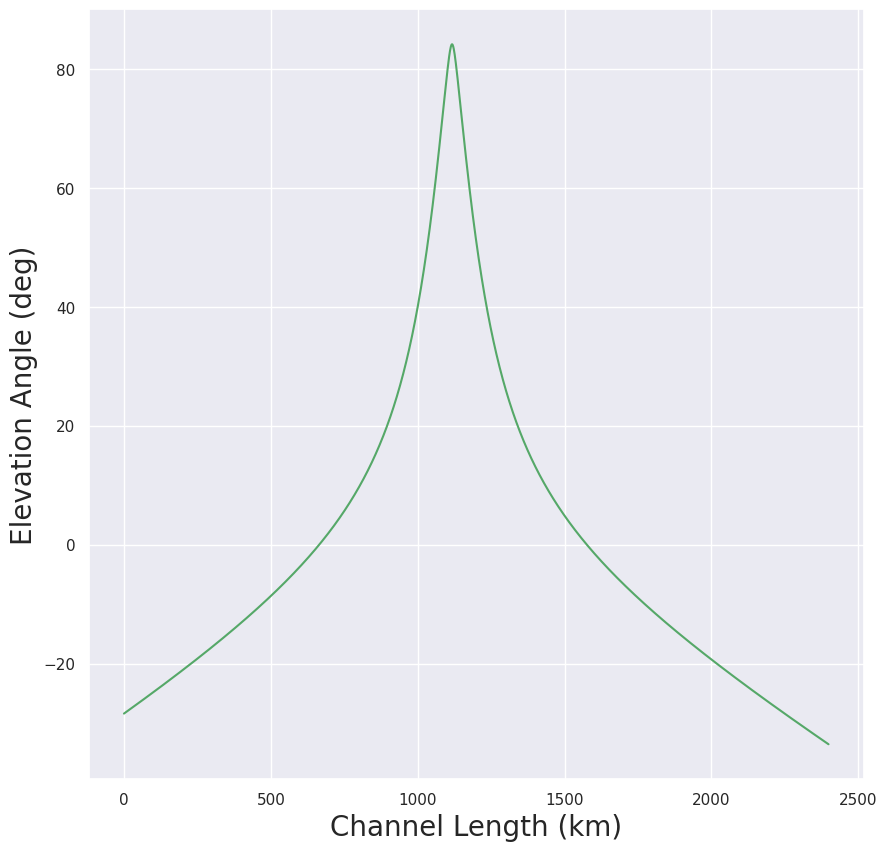

In [173]:
plt.figure(figsize=(10, 10))
plt.plot(elevation, color='g')
plt.xlabel('Channel Length (km)', fontsize=20)
plt.ylabel('Elevation Angle (deg)', fontsize=20)

In [167]:
fidelity_by_rate = {
    0.5e1: [],
    1e1: [],
    1.1e2: [],
    1.2e2: [],
    1.3e2: [],
    1.4e2: [],
    1.5e2: []
}

In [168]:
depolar_rates = [0.5e1, 1e1, 1.1e2, 1.2e2, 1.3e2, 1.4e2, 1.5e2]

In [169]:
for elev, dist in zip(elevation, distance):
  for rate in depolar_rates:
    if elev > 0:
      print(rate)
      ns.sim_reset()
      network = example_network_setup(node_distance=dist, depolar_rate=rate, dephase_rate=0.00015)

      node_a = network.get_node("Alice")
      node_b = network.get_node("Bob")

      protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)

      protocol_alice.start()
      protocol_bob.start()

      q_conn = network.get_connection(node_a, node_b, label="quantum")
      cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                         .models["timing_model"].delay)

      ns.sim_run(cycle_runtime)

      fidelity = dc.dataframe['fidelity']
      mean_fidelity.append(np.mean(fidelity))

      if rate not in fidelity_by_rate:
        fidelity_by_rate[rate] = []

      fidelity_by_rate[rate].append(fidelity)

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0
5.0
10.0
110.0
120.0
130.0
140.0
150.0


/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

In [157]:
colors = ['b', 'g', 'r', 'm', 'c', 'y']

In [158]:
rates = sorted(fidelity_by_rate.keys(), key=float)

In [159]:
data_to_plot = []
for r in rates:
    if fidelity_by_rate[r]:
      flat_data = np.concatenate([np.array(f).flatten() for f in fidelity_by_rate[r]])
    else:
      flat_data = []
    data_to_plot.append(flat_data)

<ipython-input-160-1de9b6b75f93>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(data_to_plot, labels=rates, patch_artist=True)


Text(0, 0.5, 'Fidelity')

<Figure size 1000x1000 with 0 Axes>

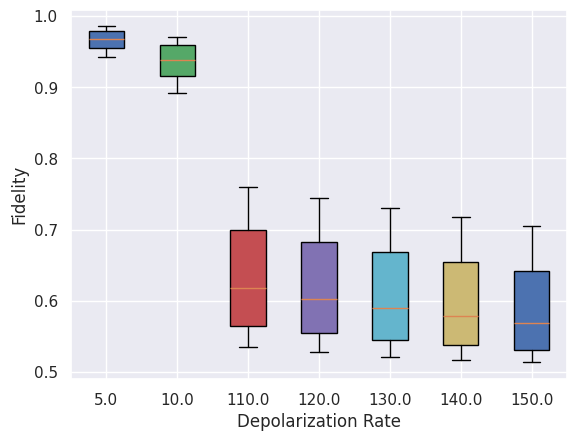

In [160]:
plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()
bplot = ax.boxplot(data_to_plot, labels=rates, patch_artist=True)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Depolarization Rate', fontsize=12)
plt.ylabel('Fidelity', fontsize=12)

In [161]:
import seaborn

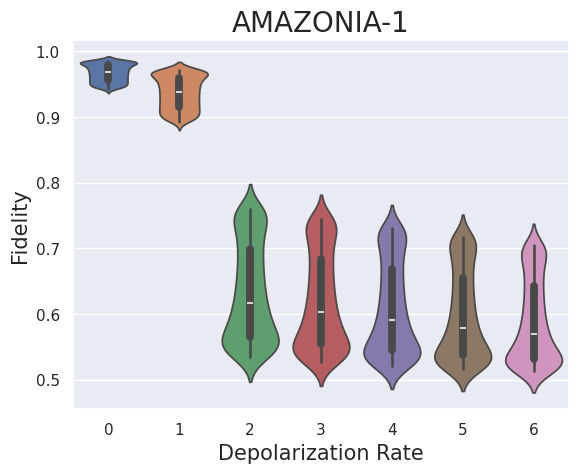

In [162]:
seaborn.set_theme()
seaborn.violinplot(data_to_plot)
#label x and y
plt.title('AMAZONIA-1', fontsize=20)
plt.xlabel('Depolarization Rate', fontsize=15)
plt.ylabel('Fidelity', fontsize=15)
plt.show()

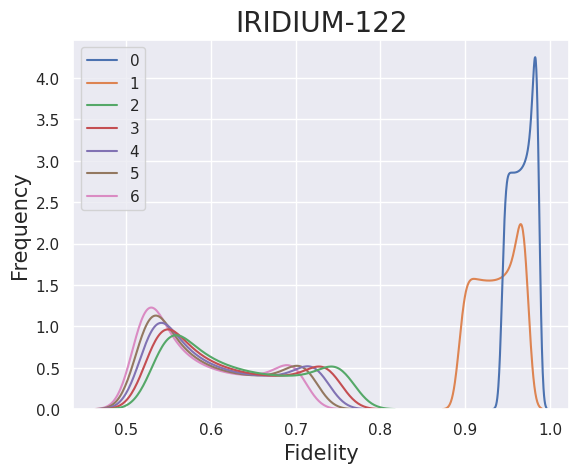

In [200]:
seaborn.kdeplot(data_to_plot, color=colors)
#label x and y
plt.title('IRIDIUM-122', fontsize=20)
plt.xlabel('Fidelity', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

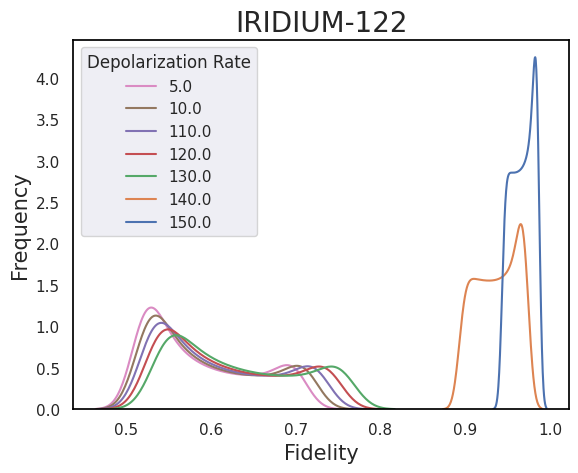

In [213]:
fig, ax = plt.subplots()
seaborn.kdeplot(data_to_plot, color=colors, ax=ax)
ax.set_xlabel('Fidelity', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('IRIDIUM-122', fontsize=20)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
ax.set_facecolor('white')
#put legend
ax.legend(rates, title='Depolarization Rate', loc='upper left')
fig.patch.set_facecolor('white')
ax.grid(False)
plt.show()

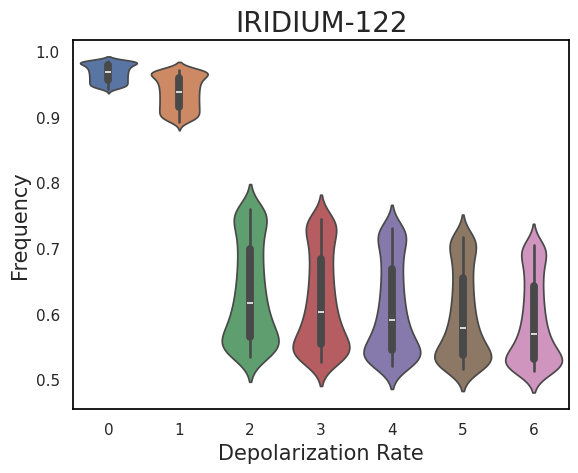

In [214]:
#the same for vi9olin
fig, ax = plt.subplots()
seaborn.violinplot(data_to_plot)
ax.set_xlabel('Depolarization Rate', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('IRIDIUM-122', fontsize=20)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.grid(False)
plt.show()

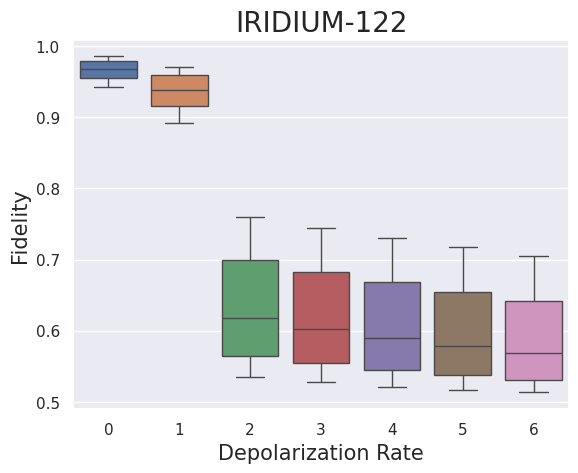

In [171]:
seaborn.set_theme()
seaborn.boxplot(data_to_plot)
#label x and y
plt.title('IRIDIUM-122', fontsize=20)
plt.xlabel('Depolarization Rate', fontsize=15)
plt.ylabel('Fidelity', fontsize=15)
plt.show()

In [183]:
for elev, dist in zip(elevation, distance):
  if elev > 0:
    valid_distances.append(dist)
    ns.sim_reset()
    network = example_network_setup(node_distance=dist, depolar_rate=1e1, dephase_rate=0.00015)
    node_a = network.get_node("Alice")
    node_b = network.get_node("Bob")
    protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)
    protocol_alice.start()
    protocol_bob.start()
    q_conn = network.get_connection(node_a, node_b, label="quantum")
    cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                     .models["timing_model"].delay)
    ns.sim_run(cycle_runtime)

    mean_low.append(np.mean(dc.dataframe['fidelity']))
    median_low.append(np.median(dc.dataframe['fidelity']))
    quantile_low.append(np.quantile(dc.dataframe['fidelity'], 0.5))
    min_val_low.append(np.min(dc.dataframe['fidelity']))
    max_val_low.append(np.max(dc.dataframe['fidelity']))
  else:
    dc.dataframe['fidelity'] = 0

/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

In [184]:
rates = sorted(fidelity_by_rate.keys())
box_data = [fidelity_by_rate[r] for r in rates]

In [185]:
fidelity_by_rate

{5.0: [0    0.942773
  Name: fidelity, dtype: float64,
  0    0.942883
  Name: fidelity, dtype: float64,
  0    0.942993
  Name: fidelity, dtype: float64,
  0    0.943104
  Name: fidelity, dtype: float64,
  0    0.943214
  Name: fidelity, dtype: float64,
  0    0.943324
  Name: fidelity, dtype: float64,
  0    0.943434
  Name: fidelity, dtype: float64,
  0    0.943544
  Name: fidelity, dtype: float64,
  0    0.943654
  Name: fidelity, dtype: float64,
  0    0.943765
  Name: fidelity, dtype: float64,
  0    0.943875
  Name: fidelity, dtype: float64,
  0    0.943985
  Name: fidelity, dtype: float64,
  0    0.944096
  Name: fidelity, dtype: float64,
  0    0.944206
  Name: fidelity, dtype: float64,
  0    0.944316
  Name: fidelity, dtype: float64,
  0    0.944427
  Name: fidelity, dtype: float64,
  0    0.944537
  Name: fidelity, dtype: float64,
  0    0.944647
  Name: fidelity, dtype: float64,
  0    0.944758
  Name: fidelity, dtype: float64,
  0    0.944868
  Name: fidelity, dtype: floa

In [186]:
for elev, dist in zip(elevation, distance):
  if elev > 0:
    valid_distances.append(dist)
    ns.sim_reset()
    network = example_network_setup(node_distance=dist, depolar_rate=1.5e1, dephase_rate=0.00015)
    node_a = network.get_node("Alice")
    node_b = network.get_node("Bob")
    protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)
    protocol_alice.start()
    protocol_bob.start()
    q_conn = network.get_connection(node_a, node_b, label="quantum")
    cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                     .models["timing_model"].delay)
    ns.sim_run(cycle_runtime)

    mean_high.append(np.mean(dc.dataframe['fidelity']))
    median_high.append(np.median(dc.dataframe['fidelity']))
  else:
    dc.dataframe['fidelity'] = 0

/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._dataframe = pd.concat([self._dataframe, data_buffer],
/usr/local/lib/python3.11/dist-packages/netsquid/util/datacollector.py:243: FutureWarning: The behavior of DataFrame concatenation with 

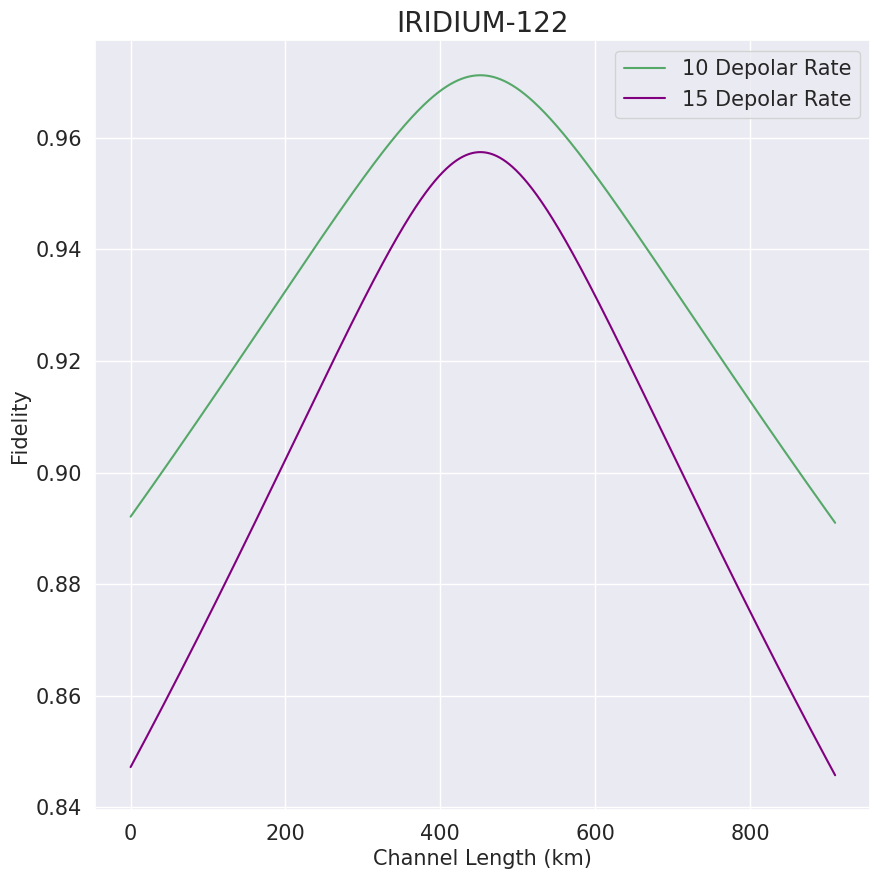

In [188]:
plt.figure(figsize=(10, 10))
plt.plot(mean_low, label='10 Depolar Rate', color='g')
plt.plot(mean_high, label='15 Depolar Rate', color='purple')
#plt.plot(median, label='Median', color='g')
#plt.plot(quantile, label='Quantile', color='r')
plt.title('IRIDIUM-122', fontsize=20)
plt.xlabel('Channel Length (km)', fontsize=15)
plt.ylabel('Fidelity', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

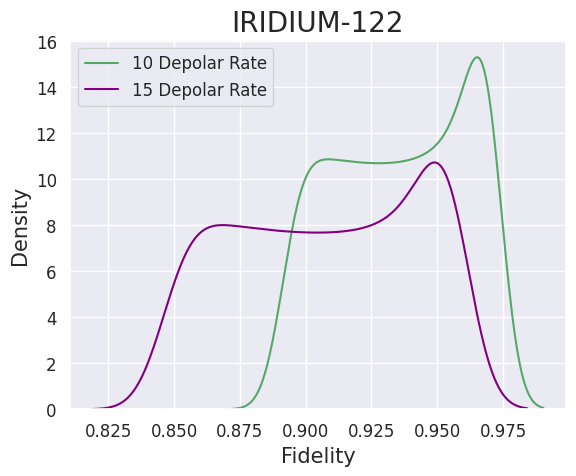

In [195]:
seaborn.set_theme()
#fidelity vs channel
seaborn.kdeplot(data=mean_low, label='10 Depolar Rate', color='g')
seaborn.kdeplot(data=mean_high, label='15 Depolar Rate', color='purple')
plt.title('IRIDIUM-122', fontsize=20)
plt.xlabel('Fidelity', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [143]:
tle_list = [
    (tle_AMAZONIA_1, 'Amazonia'),
    (tle_STARLINK_2071, 'Starlink2071'),
    (tle_IRIDIUM_122, 'Iridium122'),
    (tle_STARLINK_1008, 'Starlink1008')
]

In [144]:
start_list = [start_amazon, start_starlink, start_iridium, start_starlink_1008]
end_list = [end_amazon, end_starlink, end_iridium, end_starlink_1008]

In [145]:
colors = ['b', 'g', 'r', 'm']
dados = []

In [ ]:
for (tle, label), color, start, end in zip(tle_list, colors, start_list, end_list):
  mean = []
  median = []
  quantile = []
  min_val = []
  max_val = []
  valid_distances = []

  down_channel = DownChannel(tle, lat_unicamp, lon_unicamp, alt_unicamp)
  distance, elevation  = down_channel.calculateParameters(start, end, Step)

  for elev, dist in zip(elevation, distance):
    if elev > 0:
      valid_distances.append(dist)
      ns.sim_reset()
      network = example_network_setup(node_distance=dist, depolar_rate=1e2, dephase_rate=0.15)
      node_a = network.get_node("Alice")
      node_b = network.get_node("Bob")
      protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)
      protocol_alice.start()
      protocol_bob.start()
      q_conn = network.get_connection(node_a, node_b, label="quantum")
      cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"].models["timing_model"].delay)
      ns.sim_run(cycle_runtime)

      mean.append(np.mean(dc.dataframe['fidelity']))
      #median.append(np.median(dc.dataframe['fidelity']))
      #quantile.append(np.quantile(dc.dataframe['fidelity'], 0.5))
      #min_val.append(np.min(dc.dataframe['fidelity']))
      #max_val.append(np.max(dc.dataframe['fidelity']))

      data = {
          'Satellite': label,
          'Fidelity': mean,
          'Distance': dist
          }

      dados.append(data)


    else:
      dc.dataframe['fidelity'] = 0

    all_means.append(mean)
    all_medians.append(median)
    all_quantiles.append(quantile)
    all_mins.append(min_val)
    all_maxs.append(max_val)

  plt.figure(figsize=(20, 10))
  plt.plot(valid_distances, mean, color, label=f'{label} Mean')
  plt.xlabel('Distance (km)')
  plt.ylabel('Fidelity')
  plt.title('Fidelity vs Distance for Different Satellites')
  plt.legend()
  plt.show()

In [ ]:
df = pd.DataFrame(dados)
df_exploded = df.explode('Fidelity')
df_exploded['Fidelity'] = pd.to_numeric(df_exploded['Fidelity'])
df_exploded['Distance'] = pd.to_numeric(df_exploded['Distance'])

In [ ]:
#mean, minimum, median and quantile value sfrom df
mean_values = df_exploded.groupby('Satellite')['Fidelity'].mean()
min_values = df_exploded.groupby('Satellite')['Fidelity'].min()
median_values = df_exploded.groupby('Satellite')['Fidelity'].median()
quantile_values = df_exploded.groupby('Satellite')['Fidelity'].quantile(0.5)

distance_mean = df_exploded.groupby('Satellite')['Distance'].mean()
distance_min = df_exploded.groupby('Satellite')['Distance'].min()
distance_max = df_exploded.groupby('Satellite')['Distance'].max()

new_df = pd.DataFrame({
    'Satellite': mean_values.index,
    'Mean': mean_values,
    'Min': min_values,
    'Median': median_values,
    'Quantile': quantile_values,
    'Distance_Min': distance_min,
    'Distance_Max': distance_max,
    'Distance_Mean': distance_mean
})

In [ ]:
#categorical satellite to nuemrical
new_df['Satellite'] = new_df['Satellite'].astype('category')
new_df['Satellite'] = new_df['Satellite'].cat.codes

In [ ]:
new_df

In [ ]:
new_df = new_df.set_index("Satellite")

In [ ]:
%pip install qutip

In [ ]:
import qutip as qt
from qutip import Bloch
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

In [ ]:
node_a = network.get_node("Alice")
node_b = network.get_node("Bob")

In [ ]:
qmem_a = node_a.qmemory  # Quantum processor of Alice
qmem_b = node_b.qmemory

In [ ]:
if qmem_a.num_used_positions > 0:
  qubit_a = qmem_a.peek(0)
  print(ns.qubits.reduced_dm(qubit_a))

if qmem_b.num_used_positions > 0:
  qubit_b = qmem_b.peek(0)
  print(ns.qubits.reduced_dm(qubit_b))

In [ ]:
ns.sim_reset()
network = example_network_setup(node_distance=10, depolar_rate=0.55, dephase_rate=0.005)
node_a = network.get_node("Alice")
node_b = network.get_node("Bob")
protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)
protocol_alice.start()
protocol_bob.start()
q_conn = network.get_connection(node_a, node_b, label="quantum")
cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                 .models["timing_model"].delay)
ns.sim_run(cycle_runtime * 100)

In [ ]:
node_a.qmemory.num_used_positions

In [ ]:
node_b.qmemory.num_used_positions

In [ ]:
num_bits=8
txDiv=10e-6
sigmaPoint=0.5e-8
rx_aperture_sat=1
Cn2_sat=1e-15
wavelength=1550e-9

In [ ]:
depolar = 1e1

In [ ]:
ns.sim_reset()
network = example_network_setup(node_distance=800, depolar_rate=depolar, dephase_rate=0.00005)
node_a = network.get_node("Alice")
node_b = network.get_node("Bob")
qmemory_a = node_a.qmemory
qmemory_b = node_b.qmemory

protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)

protocol_alice.start()
protocol_bob.start()

q_conn = network.get_connection(node_a, node_b, label="quantum")
cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                 .models["timing_model"].delay)
num_qubits = 100
for i in range(num_qubits):
  ns.sim_run(cycle_runtime)

#see the qubits entangled, above
for i in range(qmemory_a.num_positions):
  qubit_a = qmemory_a.peek(i)


  print(ns.qubits.reduced_dm(qubit_a))
  rho = qt.Qobj(ns.qubits.reduced_dm(qubit_a))

  plt.figure(figsize=(10, 10))
  ax1 = plt.subplot(111, projection='3d')
  ax1.set_title(f"Memory Position : {i}")
  qt.visualization.matrix_histogram(rho, ax=ax1)
  plt.title(f'Depolar Rate : {depolar}')
  plt.show()

In [ ]:
print(qmemory_a.num_used_positions)

In [ ]:
qubit_a = qmemory_a.peek(0)
print(ns.qubits.reduced_dm(qubit_a))

In [ ]:
rho1 = qt.Qobj(ns.qubits.reduced_dm(qubit_a))

plt.figure(figsize=(10, 10))
qt.plot_wigner(rho1, cmap='magma', colorbar='magma')
plt.show()

In [ ]:
for i in range(qmemory_a.num_positions):
  qubit_a = qmemory_a.peek(i)

  rho = qt.Qobj(ns.qubits.reduced_dm(qubit_a))

  plt.figure(figsize=(5, 5))

  #ax1 = plt.subplot(111)
  #ax1.set_title(f"Memory Position : {i}")
  #qt.plot_wigner(rho, cmap='magma', colorbar='magma', ax=ax1)
  #plt.title(f'Depolar Rate : {depolar}')

  b = Bloch()

  b.ylpos = [1.1, -1.2]
  b.xlabel = ['$\\left|0\\right>+\\left|1\\right>$', '$\\left|0\\right>-\\left|1\\right>$']
  b.ylabel = ['$\\left|0\\right>+i\\left|1\\right>$', '$\\left|0\\right>-i\\left|1\\right>$']
  b.vector_color = ['b','b','b','b','b','b','r']
  b.vector_width = 6

  b.add_states(rho)

  b.show()

  plt.show()

In [ ]:
#density matrix
rho1 = qt.Qobj(ns.qubits.reduced_dm(qubit_a))
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection='3d')

qt.visualization.matrix_histogram(
    rho1,
    limits=[-0.5, 0.5, -0.1, 0.1],
    ax=ax1
)

ax1.set_title("2-Qubit Alice", fontsize=25)


plt.show()

In [ ]:
fig, ax = qt.hinton(rho1)
fig.show()

# Test Satellite : Quantum Teleports

In [ ]:
downchannel = DownChannel(tle_IRIDIUM_122, lat_unicamp, lon_unicamp, alt_unicamp)
distance, elevation  = downchannel.calculateParameters(start_iridium, end_iridium, Step)

In [ ]:
for dist, elev in zip(distance, elevation):
  if elev > 0:
    ns.sim_reset()
    network = example_network_setup(node_distance=dist, depolar_rate=1e1, dephase_rate=0.15)
    node_a = network.get_node("Alice")
    node_b = network.get_node("Bob")

    protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)

    protocol_alice.start()
    protocol_bob.start()
    q_conn = network.get_connection(node_a, node_b, label="quantum")
    cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"].models["timing_model"].delay)

    ns.sim_run(cycle_runtime)

    q_memo_a = node_a.qmemory
    q_memo_b = node_b.qmemory

    qubit_a = q_memo_a.peek(1)
    qubit_b = q_memo_b.peek(1)

    rho1 = qt.Qobj(ns.qubits.reduced_dm(qubit_a))
    #rho2 = qt.Qobj(ns.qubits.reduced_dm(qubit_b))

    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(111, projection='3d')
    ax1.set_title(f"Distance : {dist}", fontsize=25) #bigger size
    qt.visualization.matrix_histogram(
        rho1,
        limits=[-0.5, 0.5, -0.1, 0.1],
        ax=ax1
    )

    #ax1.set_title("2-Qubit Alice")
    plt.show()

In [ ]:
!pip install optisystem